In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima




In [48]:
df=pd.read_csv('Denawaka_project.csv')
df.head()





,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [49]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [50]:
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-January
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-February
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-April
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-May


In [51]:
#Slicing dataset

temperature_min=df[["Time","Temp_min"]]
temperature_min.head()




,Time,Temp_min
0,2010-January,22.1
1,2010-February,22.6
2,2010-March,23.1
3,2010-April,23.7
4,2010-May,24.0


In [52]:
#Creating time column
temperature_min['Time']=pd.to_datetime(temperature_min['Time'])


C:\Users\wasan\AppData\Local\Temp/ipykernel_16216/1826799784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_min['Time']=pd.to_datetime(temperature_min['Time'])


In [53]:
temperature_min.head()


,Time,Temp_min
0,2010-01-01,22.1
1,2010-02-01,22.6
2,2010-03-01,23.1
3,2010-04-01,23.7
4,2010-05-01,24.0


In [54]:
#Checking for missing values
temperature_min.isna().sum()


Time        0
Temp_min    1
dtype: int64

In [55]:
#removing missing values
temp=temperature_min.dropna(how="any")
temp.head()


,Time,Temp_min
0,2010-01-01,22.1
1,2010-02-01,22.6
2,2010-03-01,23.1
3,2010-04-01,23.7
4,2010-05-01,24.0


In [56]:
#Rename column
temp = temp.rename(columns = {'Temp_min': 'Temperature Min'}, inplace = False)
temp.head()




,Time,Temperature Min
0,2010-01-01,22.1
1,2010-02-01,22.6
2,2010-03-01,23.1
3,2010-04-01,23.7
4,2010-05-01,24.0


In [57]:
#Checking for missing values
temp.isna().sum()


Time               0
Temperature Min    0
dtype: int64

In [58]:
temp.set_index('Time',inplace=True)



<AxesSubplot:xlabel='Time'>

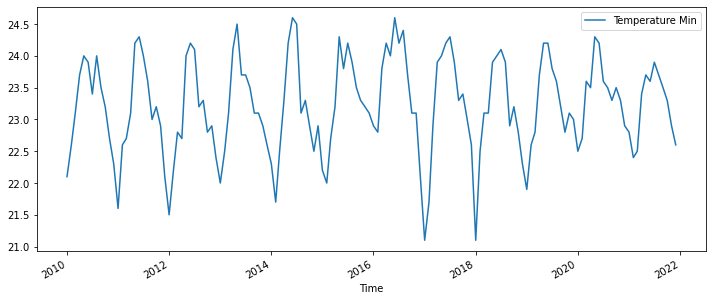

In [59]:
temp.plot(figsize=(12,5))


It can't be seen a clear trend.But there is some evidence for seasonality.

In [60]:
### ADF Test
test_result=adfuller(temp['Temperature Min'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(temp['Temperature Min'])



ADF Test Statistic : -2.4224421914762018
p-value : 0.13550218653535157
#Lags Used : 12
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing the series

In [61]:
temp['Temp First Difference'] = temp['Temperature Min'] - temp['Temperature Min'].shift(1).astype(float)



In [62]:
temp.head()


,Temperature Min,Temp First Difference
Time,,
2010-01-01,22.1,NaN
2010-02-01,22.6,0.5
2010-03-01,23.1,0.5
2010-04-01,23.7,0.6
2010-05-01,24.0,0.3


In [63]:
#Checking for missing values
temp.isna().sum()


Temperature Min          0
Temp First Difference    1
dtype: int64

In [64]:
#Removing missing values
temp=temp.dropna(how="any")
temp['Temperature Min']=temp['Temperature Min'].astype(float)
temp.isna().sum()


C:\Users\wasan\AppData\Local\Temp/ipykernel_16216/2179322096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Temperature Min']=temp['Temperature Min'].astype(float)


Temperature Min          0
Temp First Difference    0
dtype: int64

In [65]:
temp=temp.resample('MS').first()


#filling missing values
temp=temp.fillna(method='bfill')
temp.head(20)


,Temperature Min,Temp First Difference
Time,,
2010-02-01,22.6,0.5
2010-03-01,23.1,0.5
2010-04-01,23.7,0.6
2010-05-01,24.0,0.3
2010-06-01,23.9,-0.1
2010-07-01,23.4,-0.5
2010-08-01,24.0,0.6
2010-09-01,23.5,-0.5
2010-10-01,23.2,-0.3


In [66]:
#Checking for missing values
temp.isna().sum()

Temperature Min          0
Temp First Difference    0
dtype: int64

In [67]:
## Again test dickey fuller test
adfuller_test(temp['Temp First Difference'])



ADF Test Statistic : -10.517152103367128
p-value : 9.896197125574886e-19
#Lags Used : 10
Number of Observations Used : 132
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [68]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(temp['Temp First Difference'])


KPSS Statistic: 0.14666753565553822
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now the series is stationary. Therefore 1st difference series will be used.

# ACF and PACF plots

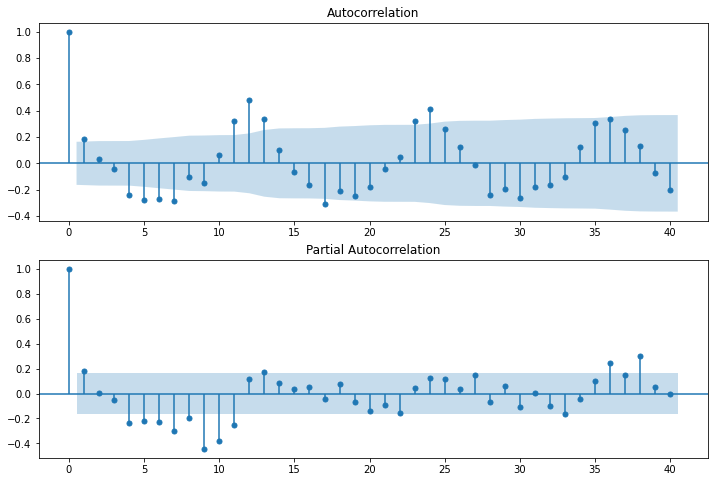

In [69]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp['Temp First Difference'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp['Temp First Difference'],lags=40,ax=ax2)


In [70]:
arima_model=auto_arima(temp['Temperature Min'].astype(float),start_p=0,start_q=0,max_p=2,max_q=3,start_P=0,start_Q=0,max_P=2,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70)



 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=324.068, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=260.137, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=239.390, Time=0.21 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=216.146, Time=0.64 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=196.460, Time=0.63 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=212.864, Time=1.83 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=202.690, Time=3.92 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=187.422, Time=1.05 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=241.318, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=203.362, Time=0.12 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=192.454, Time=0.30 sec
 ARIMA(0,0,1)(0,0,3)[12] i

C:\Users\wasan\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(1,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=166.784, Time=0.86 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=172.457, Time=1.84 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=158.555, Time=1.47 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=169.463, Time=1.73 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=201.228, Time=0.45 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=189.809, Time=0.79 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=178.886, Time=1.56 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=174.109, Time=1.07 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=167.695, Time=1.57 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=233.323, Time=0.52 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=180.376, Time=1.07 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=820.616, Time=0.69 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=203.445, Time=0.35 sec

Best model:  ARIMA

In [71]:
model=sm.tsa.statespace.SARIMAX(temp['Temperature Min'].astype('float'),order=(1, 0, 0),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Temperature Min   No. Observations:                  143
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -92.406
Date:                              Tue, 26 Apr 2022   AIC                            192.812
Time:                                      00:31:22   BIC                            204.664
Sample:                                  02-01-2010   HQIC                           197.628
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001   1357.555      0.000       0.998       1.001
ar.S.L12       0.9962      0.024     41.493      0.000       0.949       1.043
ma.S.L12      -0.9231      0.236     -3.916      0.000      -1.385      -0.461
sigma2         0.1713      0.035      4.957      0.000       0.104       0.239
===================================================================================
Ljung-Box (L1) (Q):                   7.82   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.01   Prob(JB):                         0.50
Heteroskedasticity (H):               0.98   Skew:                            -0.24
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
beg_dt='2014-01-01'
end_dt='2025-12-01'

In [81]:
#results.predict(start=beg_dt,end=end_dt,dynamic=False)

22.53957805716262

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

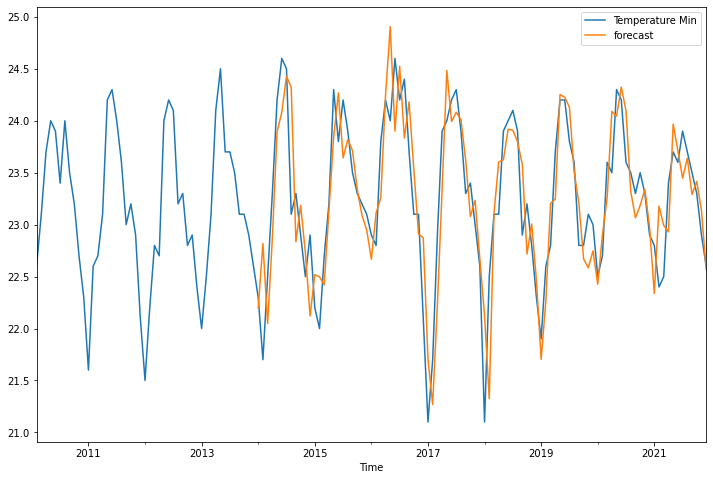

In [76]:
temp['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=False)
temp[['Temperature Min','forecast']].plot(figsize=(12,8))



In [82]:
temp.tail()


,Temperature Min,Temp First Difference,forecast
Time,,,
2021-08-01,23.7,-0.2,23.639499
2021-09-01,23.5,-0.2,23.290386
2021-10-01,23.3,-0.2,23.416934
2021-11-01,22.9,-0.4,23.135989
2021-12-01,22.6,-0.3,22.569467
